# The Advanced Computing Center for Research and Education

The Advanced Computing Center for Research and Education (ACCRE) is a computer cluster serving the high-performance computing needs of research for Vanderbilt University. In this data question, you will be analyzing data on jobs run on ACCRE's hardware.

The computing resources in the ACCRE cluster are divided into nodes. Each node is equipped with some number of CPUs, and some of the nodes contain GPUs (graphical processing units). You have been provided a dataset, accre-gpu-jobs-2022.csv, which contains information on jobs submitted to ACCRE's GPU partitions. Traditionally GPUs were designed to power video games to perform calculations quickly. Because of the nature of their design, GPUs are being used more and more for non-graphics applications as well (e.g. for deep learning applications, molecular dynamics, image processing, and much more).

Recently, more researchers are performing work that requires GPU acceleration. Your task in this project is to analyze the GPU jobs that have been run on ACCRE over the last few years in order to better understand what needs to be provisioned moving forward.

ACCRE has three scheduler partitions that groups can get access to which consist of machines each with 4 GPU cards. Each partition is named after the nvidia processor generation that it contains, from oldest to newest: maxwell, pascal, and turing. GPU nodes are requested per-GPU, and users can request up to 4 GPUs per node. For each GPU the user is allocated up to one quarter of the machine's RAM and CPU cores. All of the current GPU-accelerated hardware is also connected to a special high-speed RoCE (RDMA over converged ethernet) network allowing for memory sharing on large-scale multi-GPU jobs, so users can also request multiple servers for analysis that requires more than four GPU cards.

# The main objectives of this project are to examine the following questions:

### What is the distribution of per-GPU main memory usage over all runtime-weighed jobs in each partition? Knowing this will help ACCRE to understand our users memory needs for future hardware purchases.

### What is the distribution of the number of GPUs in each job (runtime-weighted) for each partition? What fraction of runtime-weighted and GPU-weighted jobs are using more than 4 GPUs and thus probably using the RoCE networking? Is this fraction different for each partition?

### What is the total runtime usage per-gpu (i.e. multiply runtime by the number of gpus) in each of the 3 partitions over the last year?

### What is the distribution of different groups and users accessing each partition? In each partition, who are the top users, and do they represent a majority of the runtime-weighted jobs on the partition?

### Currently there is a 5 day limit on runtime for GPU jobs, although some users have been asking for extensions. What is the distribution of requested runtime and actual runtime on jobs on each partition? Do users really need more time, or are they simply always requesting the maximum? 

## TWIX - Assigned questions 3 & 5

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt

In [4]:
df = pd.read_csv('accre-gpu-jobs-2022-v2.csv', error_bad_lines=False)
df

/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
b'Skipping line 124084: expected 12 fields, saw 13\nSkipping line 124809: expected 12 fields, saw 13\n'


,JOBID,ACCOUNT,USER,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,PARTITION,EXITCODE,STATE
0,32880657,malanga,arline,18.66M,2-00:00:00,00:13:13,1,2,1,pascal,0:0,COMPLETED
1,32880701,glasshouse,brady,0,05:00:00,00:00:22,1,3,1,maxwell,0:0,COMPLETED
2,32880718,glasshouse,brady,402.32M,05:00:00,00:08:57,1,3,1,maxwell,0:0,COMPLETED
3,32880719,glasshouse,brady,417.62M,20:00:00,05:09:46,1,1,1,pascal,0:0,COMPLETED
4,32880720,glasshouse,brady,450.09M,15:00:00,04:11:10,1,1,1,pascal,0:0,COMPLETED
...,...,...,...,...,...,...,...,...,...,...,...,...
336945,46754520_26,harovin,porsha,0,5-00:00:00,00:07:07,1,6,1,turing,0:0,RUNNING
336946,46754542,malanga,arline,0,2-00:00:00,00:00:00,0,2,1,pascal,0:0,PENDING
336947,46754560,malanga,arline,0,2-00:00:00,00:00:00,0,2,1,pascal,0:0,PENDING
336948,46754598,glasshouse,treva,145.24M,1-00:00:00,00:01:26,1,5,1,turing,0:0,COMPLETED


In [5]:
completed = df[df['STATE'] == 'COMPLETED'].replace({'USEDMEM': r'[M]+'}, {'USEDMEM': ''}, regex=True)
completed['USEDMEM'] = completed['USEDMEM'].astype(float)
completed

,JOBID,ACCOUNT,USER,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,PARTITION,EXITCODE,STATE
0,32880657,malanga,arline,18.66,2-00:00:00,00:13:13,1,2,1,pascal,0:0,COMPLETED
1,32880701,glasshouse,brady,0.00,05:00:00,00:00:22,1,3,1,maxwell,0:0,COMPLETED
2,32880718,glasshouse,brady,402.32,05:00:00,00:08:57,1,3,1,maxwell,0:0,COMPLETED
3,32880719,glasshouse,brady,417.62,20:00:00,05:09:46,1,1,1,pascal,0:0,COMPLETED
4,32880720,glasshouse,brady,450.09,15:00:00,04:11:10,1,1,1,pascal,0:0,COMPLETED
...,...,...,...,...,...,...,...,...,...,...,...,...
336933,46753813,harovin,shannon,137.96,5-00:00:00,00:00:52,1,1,1,turing,0:0,COMPLETED
336934,46753820_26,harovin,porsha,5093.70,5-00:00:00,00:34:51,1,6,1,turing,0:0,COMPLETED
336936,46753823,harovin,shannon,156.21,5-00:00:00,00:04:03,1,1,1,turing,0:0,COMPLETED
336942,46754095,harovin,shannon,2820.52,5-00:00:00,00:11:13,1,1,1,turing,0:0,COMPLETED


In [6]:
def time_to_hours(col): # Where col is a series gotten from the dataframe

    # Each row in USEDTIME/REQTIME is of the format:
    # Days-H:M:S
    # So we should be able to just take every value and convert them to seconds, then convert that final number to hours

    output_col = []
    for item in col:
        total_seconds = 0
        # item should be a string, ie 2-10:19:00
        # Split based on the :
        values = item.split(":")

        # Using the example 2-10:19:00
        total_seconds += float(values[2])       # 00
        total_seconds += float(values[1]) * 60  # 19

        # We can't just add values[0] because there's a chance it has a day attached to it
        # So values[0] may actually "2-10"
        if "-" in values[0]:
            day_split = values[0].split("-")
            total_seconds += float(day_split[1]) * 60 * 60      # 10
            total_seconds += float(day_split[0]) * 60 * 60 * 24 # 2
        else:
            total_seconds += float(values[0]) * 60 * 60         # 10

        # Convert seconds to hours
        total_hours = total_seconds / 60 / 60
        output_col.append(total_hours)
    return output_col


In [7]:
# print first 10 items
time_to_hours(completed["REQTIME"])[:10]

[48.0, 5.0, 5.0, 20.0, 15.0, 84.0, 84.0, 48.0, 96.0, 96.0]

In [8]:
# If you run this cell more than once you'll get an error - this means the column was already converted
# Just reset the completed df by running the code above that defines completed

completed["REQTIME"] = time_to_hours(completed["REQTIME"])
completed["USEDTIME"] = time_to_hours(completed["USEDTIME"])

In [9]:
completed

,JOBID,ACCOUNT,USER,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,PARTITION,EXITCODE,STATE
0,32880657,malanga,arline,18.66,48.0,0.220278,1,2,1,pascal,0:0,COMPLETED
1,32880701,glasshouse,brady,0.00,5.0,0.006111,1,3,1,maxwell,0:0,COMPLETED
2,32880718,glasshouse,brady,402.32,5.0,0.149167,1,3,1,maxwell,0:0,COMPLETED
3,32880719,glasshouse,brady,417.62,20.0,5.162778,1,1,1,pascal,0:0,COMPLETED
4,32880720,glasshouse,brady,450.09,15.0,4.186111,1,1,1,pascal,0:0,COMPLETED
...,...,...,...,...,...,...,...,...,...,...,...,...
336933,46753813,harovin,shannon,137.96,120.0,0.014444,1,1,1,turing,0:0,COMPLETED
336934,46753820_26,harovin,porsha,5093.70,120.0,0.580833,1,6,1,turing,0:0,COMPLETED
336936,46753823,harovin,shannon,156.21,120.0,0.067500,1,1,1,turing,0:0,COMPLETED
336942,46754095,harovin,shannon,2820.52,120.0,0.186944,1,1,1,turing,0:0,COMPLETED


In [118]:
completed['REQTIME'] = completed['REQTIME'].astype(float)
completed['USEDTIME'] = completed['USEDTIME'].astype(float)
completed['TIME_DIFF_HR'] = completed['REQTIME'] - completed['USEDTIME']
completed

,JOBID,ACCOUNT,USER,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,PARTITION,EXITCODE,STATE,TIME_DIFF_HR,USAGE_PER_GPU
0,32880657,malanga,arline,18.66,48.0,0.220278,1,2,1,pascal,0:0,COMPLETED,47.779722,0.220278
1,32880701,glasshouse,brady,0.00,5.0,0.006111,1,3,1,maxwell,0:0,COMPLETED,4.993889,0.006111
2,32880718,glasshouse,brady,402.32,5.0,0.149167,1,3,1,maxwell,0:0,COMPLETED,4.850833,0.149167
3,32880719,glasshouse,brady,417.62,20.0,5.162778,1,1,1,pascal,0:0,COMPLETED,14.837222,5.162778
4,32880720,glasshouse,brady,450.09,15.0,4.186111,1,1,1,pascal,0:0,COMPLETED,10.813889,4.186111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336933,46753813,harovin,shannon,137.96,120.0,0.014444,1,1,1,turing,0:0,COMPLETED,119.985556,0.014444
336934,46753820_26,harovin,porsha,5093.70,120.0,0.580833,1,6,1,turing,0:0,COMPLETED,119.419167,0.580833
336936,46753823,harovin,shannon,156.21,120.0,0.067500,1,1,1,turing,0:0,COMPLETED,119.932500,0.067500
336942,46754095,harovin,shannon,2820.52,120.0,0.186944,1,1,1,turing,0:0,COMPLETED,119.813056,0.186944


### What is the distribution of per-GPU main memory usage over all runtime-weighed jobs in each partition? Knowing this will help ACCRE to understand our users memory needs for future hardware purchases.

In [52]:
completed_5000M_2HR = completed[(completed['USEDMEM']<5000) & (completed['USEDTIME']<2)]
completed_outliers = completed[(completed['USEDMEM']>5000) & (completed['USEDTIME']>2)]
completed_TIMEDIFF_OVER12HR = completed[completed['TIME_DIFF_HR']>12]
print(completed_5000M_2HR.shape)
print(completed_outliers.shape)
print(completed_TIMEDIFF_OVER12HR.shape)

(243555, 14)
(7312, 14)
(62875, 14)


<AxesSubplot:>

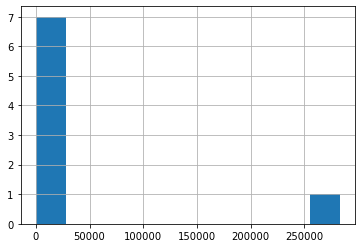

In [90]:
completed['TIME_DIFF_HR'].describe().hist()

In [54]:
completed['TIME_DIFF_HR'].describe()

count    283333.000000
mean         22.527946
std          33.752488
min         -20.064722
25%           5.995000
50%           9.951667
75%          11.626667
max         273.769444
Name: TIME_DIFF_HR, dtype: float64

In [91]:
print(completed[completed['TIME_DIFF_HR'] > 12].shape)
print(completed[completed['TIME_DIFF_HR'] < 12].shape)
print("The portion of jobs that have below 12 hrs in difference between REQTIME and USEDTIME is " + str(220457/283333*100) + "%")

(62875, 14)
(220457, 14)
The portion of jobs that have below 12 hrs in difference between REQTIME and USEDTIME is 77.80844448052292%


<AxesSubplot:xlabel='TIME_DIFF_HR', ylabel='Count'>

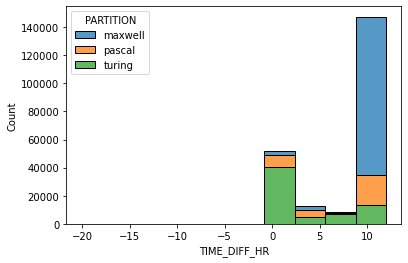

In [111]:
sns.histplot(data=completed[completed['TIME_DIFF_HR']<12], x="TIME_DIFF_HR", hue="PARTITION", multiple="stack", bins=10) #meaningful 

# Top 5 Greedy Users

In [86]:
completed.sort_values(by='TIME_DIFF_HR', ascending=False).head(5)[['ACCOUNT','USER','REQTIME','USEDTIME','TIME_DIFF_HR']]

,ACCOUNT,USER,REQTIME,USEDTIME,TIME_DIFF_HR
60205,glasshouse,brodie,360.0,86.230556,273.769444
60204,glasshouse,brodie,360.0,88.015556,271.984444
332773,pinole,booker,264.0,25.931667,238.068333
333065,glasshouse,jolette,120.0,0.000000,120.000000
317691,harovin,porsha,120.0,0.000000,120.000000


# Greedy Users with TIME_DIFF_HR over 100 HR

In [105]:
completed[completed['TIME_DIFF_HR']>90]

,JOBID,ACCOUNT,USER,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,PARTITION,EXITCODE,STATE,TIME_DIFF_HR,USAGE_PER_GPU
65,32880916,sunburst,demarcus,151.40,96.0,0.092500,1,1,1,pascal,0:0,COMPLETED,95.907500,0.092500
66,32880917,sunburst,demarcus,143.45,96.0,0.091111,1,1,1,pascal,0:0,COMPLETED,95.908889,0.091111
67,32880918,sunburst,demarcus,140.25,96.0,0.081389,1,1,1,pascal,0:0,COMPLETED,95.918611,0.081389
68,32880919,sunburst,demarcus,156.66,96.0,0.678056,1,1,1,pascal,0:0,COMPLETED,95.321944,0.678056
69,32880920,sunburst,demarcus,173.94,96.0,1.148889,1,1,1,pascal,0:0,COMPLETED,94.851111,1.148889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336929,46753800,harovin,shannon,160.03,120.0,0.010278,1,1,1,turing,0:0,COMPLETED,119.989722,0.010278
336933,46753813,harovin,shannon,137.96,120.0,0.014444,1,1,1,turing,0:0,COMPLETED,119.985556,0.014444
336934,46753820_26,harovin,porsha,5093.70,120.0,0.580833,1,6,1,turing,0:0,COMPLETED,119.419167,0.580833
336936,46753823,harovin,shannon,156.21,120.0,0.067500,1,1,1,turing,0:0,COMPLETED,119.932500,0.067500


<AxesSubplot:xlabel='TIME_DIFF_HR', ylabel='Count'>

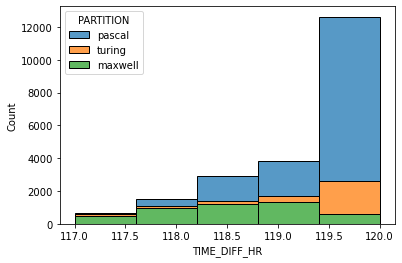

In [117]:
sns.histplot(data=completed[(completed['TIME_DIFF_HR']>117) & (completed['TIME_DIFF_HR']<200)], x="TIME_DIFF_HR", hue="PARTITION", multiple="stack", bins=5) #meaningful 

In [11]:
q4 = completed[(completed['USER']=='porsha') & (completed['PARTITION']=='turing')]
q4['USEDTIME'].sum()

72051.22499999999

In [12]:
completed.groupby(["PARTITION","USER"])["USEDTIME"].sum().sort_values(ascending=False).head(40)

PARTITION  USER      
turing     porsha        72051.225000
pascal     collins       36128.736389
           jolette       35495.081111
           birdella      32735.093056
           nakisha       25576.947500
turing     collins       23290.541667
pascal     erick         21532.426111
maxwell    collins       16096.124722
           jolette       10501.501111
pascal     debera        10157.885833
turing     valentina      9929.354444
           margret        9316.541111
maxwell    erick          9295.141389
pascal     brady          8782.690278
turing     shannon        8178.542500
maxwell    suzanna        6463.001389
turing     treva          6414.418333
pascal     wilhelmina     6031.874167
           jonnie         5281.844722
maxwell    marnie         5052.001667
           davonta        4594.072500
turing     jonnie         4102.137778
pascal     nobie          3886.196667
           miya           3490.960556
maxwell    porsha         3460.863889
pascal     andra          33

In [13]:
completed.groupby(["USER","PARTITION"])["USEDTIME"].sum().sort_values(ascending=False).head(40)

USER        PARTITION
porsha      turing       72051.225000
collins     pascal       36128.736389
jolette     pascal       35495.081111
birdella    pascal       32735.093056
nakisha     pascal       25576.947500
collins     turing       23290.541667
erick       pascal       21532.426111
collins     maxwell      16096.124722
jolette     maxwell      10501.501111
debera      pascal       10157.885833
valentina   turing        9929.354444
margret     turing        9316.541111
erick       maxwell       9295.141389
brady       pascal        8782.690278
shannon     turing        8178.542500
suzanna     maxwell       6463.001389
treva       turing        6414.418333
wilhelmina  pascal        6031.874167
jonnie      pascal        5281.844722
marnie      maxwell       5052.001667
davonta     maxwell       4594.072500
jonnie      turing        4102.137778
nobie       pascal        3886.196667
miya        pascal        3490.960556
porsha      maxwell       3460.863889
andra       pascal        33

## What is the total runtime usage per-gpu (i.e. multiply runtime by the number of gpus) in each of the 3 partitions over the last year?

In [14]:
completed_q3 = completed
completed_q3["USAGE_PER_GPU"] = completed_q3["GPUS"] * completed_q3["USEDTIME"]
completed_q3.groupby(["PARTITION"])["USAGE_PER_GPU"].sum()

PARTITION
maxwell     92701.636667
pascal     334872.838056
turing     204650.596667
Name: USAGE_PER_GPU, dtype: float64

## What fraction of runtime-weighted and GPU-weighted jobs are using more than 4 GPUs and thus probably using the RoCE networking?

In [15]:
# What fraction of GPU jobs are using more than 4 GPUs aka using RoCE networking

In [16]:
RoCE_networking = completed[completed['GPUS']>=4]
RoCE_networking['GPUS'].unique() #users can request up to 4 GPUs per node

array([ 4, 32, 18,  8, 12, 16, 24, 40, 60,  6, 20])

In [17]:
print(completed.shape), print(RoCE_networking.shape)

(283333, 14)
(2895, 14)


(None, None)

In [18]:
print('Of the total completed jobs, the fraction of GPU jobs using RoCE networking is ' + str(2895/283333*100) +'%')

Of the total completed jobs, the fraction of GPU jobs using RoCE networking is 1.0217659079598918%


In [19]:
completed.head()

,JOBID,ACCOUNT,USER,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,PARTITION,EXITCODE,STATE,TIME_DIFF_HR,USAGE_PER_GPU
0,32880657,malanga,arline,18.66,48.0,0.220278,1,2,1,pascal,0:0,COMPLETED,47.779722,0.220278
1,32880701,glasshouse,brady,0.00,5.0,0.006111,1,3,1,maxwell,0:0,COMPLETED,4.993889,0.006111
2,32880718,glasshouse,brady,402.32,5.0,0.149167,1,3,1,maxwell,0:0,COMPLETED,4.850833,0.149167
3,32880719,glasshouse,brady,417.62,20.0,5.162778,1,1,1,pascal,0:0,COMPLETED,14.837222,5.162778
4,32880720,glasshouse,brady,450.09,15.0,4.186111,1,1,1,pascal,0:0,COMPLETED,10.813889,4.186111


In [20]:
completed['USEDMEM'].describe()

count    283333.000000
mean       2240.911704
std        6434.562929
min           0.000000
25%           7.530000
50%        1176.880000
75%        2179.520000
max      371247.350000
Name: USEDMEM, dtype: float64

In [21]:
print(completed[completed['USEDMEM'] > 5000].shape)
print(completed[completed['USEDMEM'] < 5000].shape)
print("The portion of jobs that used below 5000 MB of memory is " + str(255138/283333*100) + "%")

(28195, 14)
(255138, 14)
The portion of jobs that used below 5000 MB of memory is 90.04881182213155%


<AxesSubplot:>

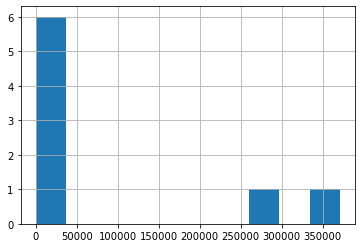

In [22]:
completed['USEDMEM'].describe().hist()  #Majority of data lies below 5000MB of USEDMEM

In [23]:
completed['USEDTIME'].describe()

count    283333.000000
mean          1.571967
std           9.645471
min           0.000000
25%           0.006111
50%           0.055278
75%           0.151667
max         195.259444
Name: USEDTIME, dtype: float64

In [24]:
print(completed[completed['USEDTIME'] > 2].shape)
print(completed[completed['USEDTIME'] < 2].shape)
print("The portion of jobs that requires less than 2 hours is " + str(264436/283333*100) + "%")

(18892, 14)
(264436, 14)
The portion of jobs that requires less than 2 hours is 93.33046274172088%


<AxesSubplot:>

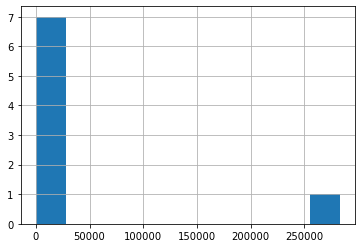

In [25]:
completed['USEDTIME'].describe().hist()    #Majority of data lies below 5000 MB of USEDMEM

<AxesSubplot:xlabel='USEDMEM', ylabel='Count'>

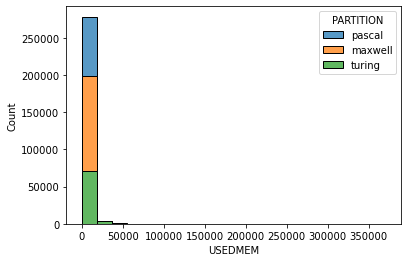

In [26]:
sns.histplot(data=completed, x="USEDMEM", hue="PARTITION", multiple="stack", bins=20) #not meaningful

<AxesSubplot:xlabel='USEDMEM', ylabel='Count'>

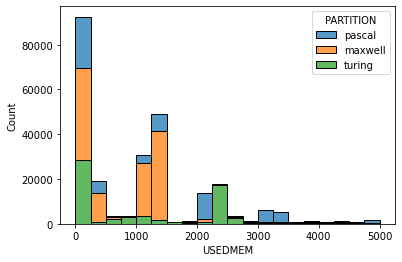

In [27]:
sns.histplot(data=completed[completed["USEDMEM"] < 5000], x="USEDMEM", hue="PARTITION", multiple="stack", bins=20) #meaningful 

In [28]:
np.mean(completed["USEDMEM"] < 5000) 

0.9004881182213156

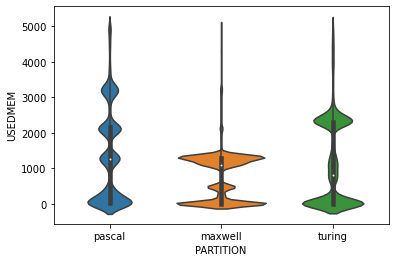

<AxesSubplot:xlabel='PARTITION', ylabel='USEDMEM'>

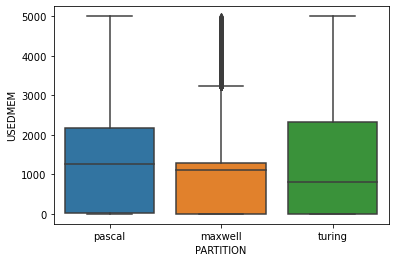

In [29]:
# violin plot of memory usage
sns.violinplot(data=completed[completed["USEDMEM"] < 5000], x="PARTITION", y="USEDMEM")
plt.show()
sns.boxplot(data=completed[completed["USEDMEM"] < 5000], x="PARTITION", y="USEDMEM")

<AxesSubplot:xlabel='USEDTIME', ylabel='USEDMEM'>

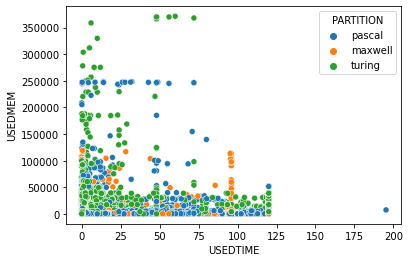

In [30]:
ax = sns.scatterplot(x = completed["USEDTIME"], y = completed["USEDMEM"], hue = completed["PARTITION"])
ax

In [31]:
df['EXITCODE'].unique()

array(['0:0', '127:0', '0:2', '1:0', '0:15', '0:9', '2:0', '0:6', '7:0',
       '126:0', '33:0', '13:0', '16:0', '0:125', '9:0', '0:7'],
      dtype=object)

In [32]:
completed['NODES'].unique()

array([ 1,  7,  5,  2,  3,  4, 10, 15,  6])

In [33]:
completed['GPUS'].unique()

array([ 1,  2,  4,  3, 32, 18,  8, 12, 16, 24, 40, 60,  6, 20])

In [34]:
completed[completed['GPUS'] == 18]

,JOBID,ACCOUNT,USER,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,PARTITION,EXITCODE,STATE,TIME_DIFF_HR,USAGE_PER_GPU
11851,32974293,glasshouse,arlyne,33235.74,20.0,4.035000,5,5,18,maxwell,0:0,COMPLETED,15.965000,72.63
63358,37545685,glasshouse,jones,415.32,20.0,0.034444,5,50,18,maxwell,0:0,COMPLETED,19.965556,0.62
63359,37545693,glasshouse,jones,704.08,20.0,0.565556,5,50,18,maxwell,0:0,COMPLETED,19.434444,10.18
63369,37547119,glasshouse,jones,701.76,20.0,0.486111,5,50,18,maxwell,0:0,COMPLETED,19.513889,8.75


In [35]:
completed['CPUS'].unique()

array([  2,   3,   1,   6,  12,   4,   8,  18,   7,   5,  24,  30,   9,
        20,  16,  36,  80, 120,  50,  10,  21,  70,  25,  17,  40,  14,
        33,  72,  11,  60,  13,  69,  28,  35,  26,  29])

In [36]:
completed.isnull().values.any() #no NaN value in the entire Completed dataset

False